## Semantic Segmentation

So far we have seen image classification problem where we determine the class of an image. But in semantic segmentation we will determine the category of each pixel of an image. For example, a cat is running on the field. Here we will determine cat, grass, background etc. for that image.

In semantic segmentation we just label each pixel of the image but don't differentiate instances. For example, if two cows is next to each other in an image it will only label as cow but will not differntiate as two different cow. This is the shortcomings of semantic segmentation.

![alt text](images/ss1.PNG)

 ## Semantic Segmentation Idea

 ##### Idea 1 (Sliding Window)

 We can do semantic segmentation using CNN. The idea is to apply sliding window approach. We take our input image and break it into many many small crops of this image. Now we will consider each of this crop as an image and consider as a classification problem. We will classify the central pixel of each crop. This would work to some extent. But this is computationally bad. Because this would be computationally expensive to run forward and backward pass. However, we can share features between two patches that are right next to each other. Because the convolutional features of those patches go through same Convolutional layers. Therfore, we can share lot of computation when applying this to separate passes. However, this is an terrible idea.

![alt text](images/ss2.PNG)

##### Idea 2 (Convolution)
"The idea of fully connected layer". In this process instead of extracting individual patches of the image we will take the whole image as input an pass it through a whole giant stack of convolutional layers with no fully connected layers or anything. By doing so we will end up getting a output tensors of size [C X H X W]. Here, C is the number of categories, H and W are height and width respectively. This tensor consist of just the classification scores for evey pixels of the input image. We will compute clssification loss(cross entropy loss), backpropagation for each pixel. Well the training data should be labeled with each pixel for this task which is very expensive.

**Problems:**
- Classification architecture reduces the spatial size of the image when going deeper, but the spatial size remains the same in semantic segmentation.
- convolution at original image resolution at every step is very expensive.


![alt text](images/ss3.PNG)

**Solution**:
Rather than keeping the spatial size of the image same throughtout all the convolutional layers we can design the architecture like something else. In this architecure we will run some convolutional layer with the same spatial size, then downsapmple that feature map using maxpooling or striped convolutions. Then rather than trnasitioning this downsampled image to a fully connected layer we will again increase the spatial size of the image so that the image can have the same size as the input.

![alt text](images/ss4.PNG/)


So far we have seen, downsampling layer in CNNs, but nevers discussed upsampling.
The idea for upsampling is something like unpooling the. Several techniques for up-sampling.
- Nearest Neighbor Unpooling: Here in our example, the input is 2X2 image and after upsampling the image is 4X4. Here we have done a two by two stride to the neares neighbor unpooling where we have duplicated that element for every point in our two by two receptive field of the unpooling region.

- Bed of nails: In this case for the same input(2X2 receptive field), we will put all zeros except for the element of the unpooling region. In this case we have put the inputs in the upper left corner and everything else is zero.

![alt text](images/ss5.PNG)

- **Max unpooling**: In this process we will remember the position of the value in the image which is used and put in the downsampled image using max pooling. Now at time of unpooling the downsampled image, we will put the value in that position, and every other position is filled with zeros.
By doing so, it becomes more of a sense to keep the spatial information same from the original image. Because when we put the value in the same slot it might handle the fine detatils of the image.

![alt text](images/ss6.PNG)

- **Traspose Convolution**: The above discussed methods are fixed function. They don't learn how to upsample. There is a convolution type name "striped convolution" which is a learnable layer that can learn the way the network wants to perform down sampling. By the analogy with that there is a type of layer called "Transpose convolution" that can learn while upsampling. So it upsamples the feature map and lean some weights about how it wants to do that upsampling as well.

    But stripped downsampling is actually a convolution. How? Well, remember that, when we have a input image of size 4x4, with filter size 3, padding 1, stride 1 we will have output of size 4x4. But if we use stride 2 then the output will be of size 2x2. This means image is downsampled with some learnable weights. Stride refers to the ratio of how much we move the kernal in the input and in the output. Therefore in this case the stride is 2.

    The upsampling is therefore nothing but transpose convolution. But here the input is 2x2 and output will be 4x4. Here we don't use dot product between the kernal and the weithts. Instead we will take one value from the input and multiply it all the weights of the kernal and put all the values having shape of kernal size in the output. Here the stride is 1/2. Therefore sometimes it is called fractional convolution. The tricky part is sometimes the receptive fields in the ouput might overlap. we will add those values. So we can say, this is kind of learnable upsampling because we used learned convolutional filter weights.

![alt text](images/ss7.PNG) ![alt text](images/ss8.PNG)

![alt text](images/ss9.PNG) 
![alt text](images/ss9.PNG) 

![alt text](images/ss12.PNG)

Therefore we can take an input image and pass it through this gigantic convolutional layer consisting of downsampling and upsampling for semantic Segmentation. We can train this whole thing with backpropagation using cross entropy loss over every pixel.

### Implementation
Now it's time to put all these together in code. We will here apply Fully convolutional Network for semantic segmentation. we  will use tensorflow, keras here for this task.

Used code from this link: https://www.kaggle.com/code/abhinavsp0730/semantic-segmentation-by-implementing-fcn

In [1]:
# importing the libraries
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
from IPython.display import clear_output
import matplotlib.pyplot as plt

c:\Users\klikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


In [3]:
# normalize the images
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [4]:
# resizing the train dataset image to H x W = 128 x 128
# performing image augmentation to increase the dataset size
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [5]:
# resizing the test dataset image to H x W = 128 x 128
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [6]:
# defining some hyperparameters
TRAIN_LENGTH = info.splits['train'].num_examples
BUFFER_SIZE = 1000
BATCH_SIZE = 128
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
# defining the input pipeline
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [8]:
# function for showing sample images and its mask from the dataset
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

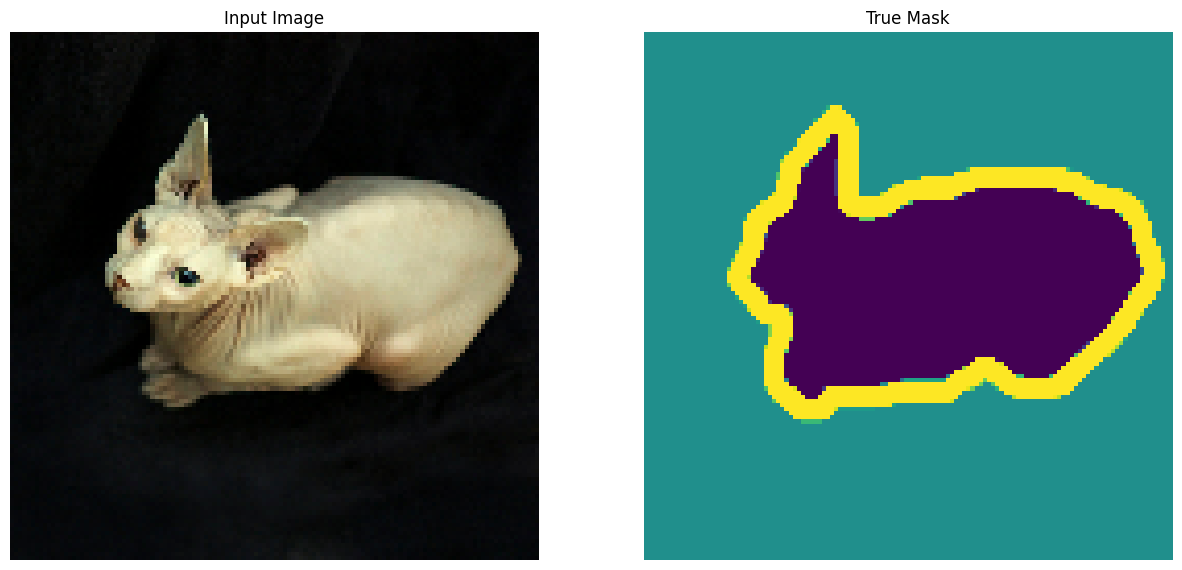

In [9]:
# train.take(1) method takes the first element f
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *
# from tensorflow.keras.applications import NASNetLarge


In [11]:
def fcn(image_size, ch_in=3, ch_out=3):
    
    inputs = Input(shape=(*image_size, ch_in), name='input')

    # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    # Recovering the feature maps generated by each of the 3 final blocks:
    f3 = vgg16.get_layer('block3_pool').output  
    f4 = vgg16.get_layer('block4_pool').output  
    f5 = vgg16.get_layer('block5_pool').output  

    # Replacing VGG dense layers by convolutions:
    f5_conv1 = Conv2D(filters=4086, kernel_size=7, padding='same',
                      activation='relu')(f5)
    f5_drop1 = Dropout(0.5)(f5_conv1)
    f5_conv2 = Conv2D(filters=4086, kernel_size=1, padding='same',
                      activation='relu')(f5_drop1)
    f5_drop2 = Dropout(0.5)(f5_conv2)
    f5_conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f5_drop2)


    # Using a transposed conv (w/ s=2) to upscale `f5` into a 14 x 14 map
    # so it can be merged with features from `f4_conv1` obtained from `f4`:
    f5_conv3_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(f5)
    f4_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f4)

    # Merging the 2 feature maps (addition):
    merge1 = add([f4_conv1, f5_conv3_x2])

    # We repeat the operation to merge `merge1` and `f3` into a 28 x 28 map:
    merge1_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(merge1)
    f3_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f3)
    merge2 = add([f3_conv1, merge1_x2])

    # Finally, we use another transposed conv to decode and up-scale the feature map
    # to the original shape, i.e., using a stride 8 to go from 28 x 28 to 224 x 224 here:
    outputs = Conv2DTranspose(filters=ch_out, kernel_size=16, strides=8,
                              padding='same', activation=None)(merge2)
    
    fcn_model = Model(inputs, outputs)
    return fcn_model

In [12]:
# defining the tensorflow distribute strategy
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [13]:
# calling the model inside the scope
with strategy.scope():
  model = fcn(image_size=(128, 128))
  # compiling the model with the optimizer, loss function and acc metrics
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
#displaying the model structure
# tf.keras.utils.plot_model(model, show_shapes=True)
print(model)

In [15]:
# function to create the mask
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [16]:
# function to show the prediction
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 591ms/step


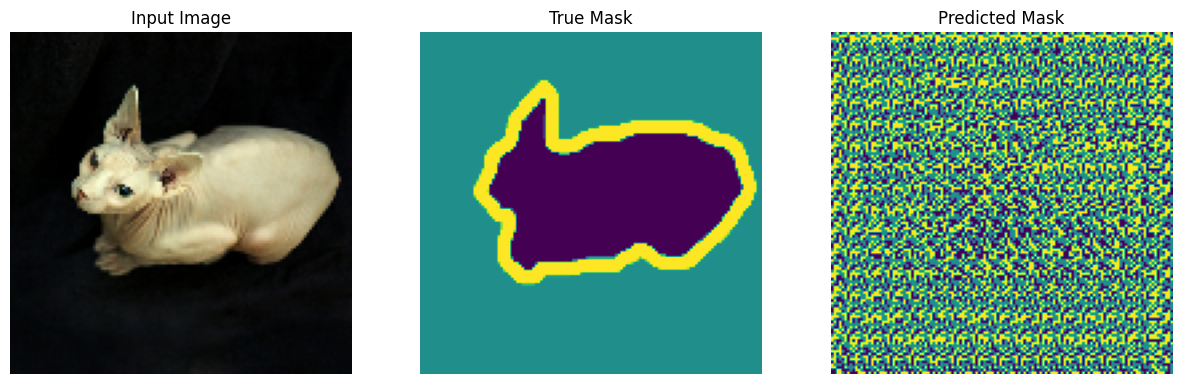

In [17]:
show_predictions()

In [18]:
# calllback to displaying the predictions of our model while training
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
   
 # ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)

1/1 [==============================] - 0s 144ms/step


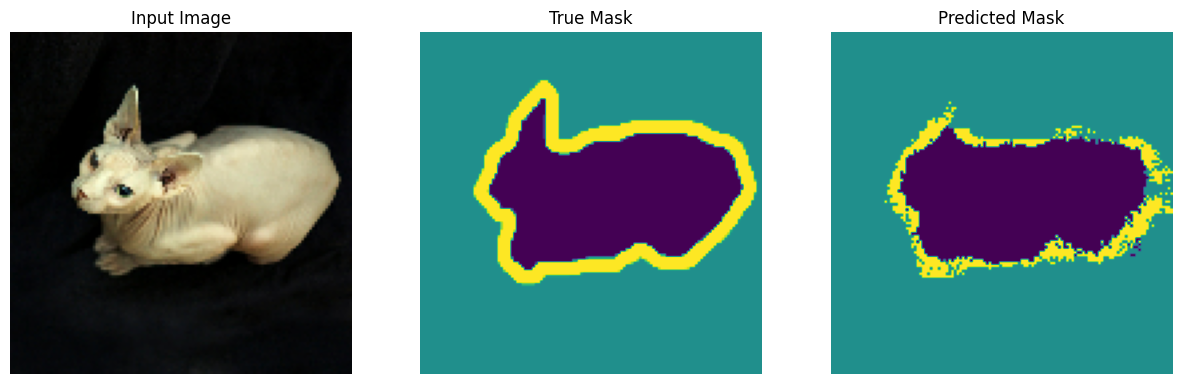


Sample Prediction after epoch 30

28/28 [==============================] - 834s 30s/step - loss: 0.3209 - accuracy: 0.8650 - val_loss: 0.3516 - val_accuracy: 0.8546 - lr: 0.0010


In [19]:
EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), reduce_lr, early_stopping])

If we increase the number of epochs then there will be more accuracy. May be later I will run for more epochs.